In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, pearsonr
import warnings
from decimal import getcontext

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

plt.rcParams.update({'font.size': 12})

getcontext().prec = 28

csv_path = r"./merged_scores.csv"
score_leaderboard = ["mmlu_pro", "eq_bench", "arena_cw", "arena_all", "livebench"]

In [4]:
def read_merged_scores_csv(csv_path):
    df = pd.read_csv(csv_path)

    association_distance_scores = {}

    for _, row in df.iterrows():
        model_name = row['model']
        association_distance = row['association_distance']
        association_distance_scores[model_name] = float(association_distance)

    return association_distance_scores


def read_arena_ranks_from_csv(csv_path):
    df = pd.read_csv(csv_path)

    arena_ranks = {}
    for _, row in df.iterrows():
        model_name = row['model']
        model_data = {}

        for column in df.columns:
            if column not in ['model', 'association_distance']:
                value = row[column]
                if pd.notna(value):
                    model_data[column] = float(value)

        arena_ranks[model_name] = model_data

    return arena_ranks

association_distance_scores = read_merged_scores_csv(csv_path)
arena_ranks = read_arena_ranks_from_csv(csv_path)


In [5]:
def calculate_correlations(association_distance_scores, arena_ranks, score_leaderboard, correlation_type="spearman"):
    correlation_results = {}

    leaderboard_names = set()
    for model_data in arena_ranks.values():
        leaderboard_names.update(model_data.keys())

    for leaderboard in leaderboard_names:
        if leaderboard not in score_leaderboard:
            continue

        common_models = []
        our_scores = []
        leaderboard_scores = []

        for model, score in association_distance_scores.items():
            if model in arena_ranks and leaderboard in arena_ranks[model]:
                common_models.append(model)
                our_scores.append(score)
                leaderboard_scores.append(arena_ranks[model][leaderboard])

        result = {
            "correlation": None,
            "p_value": None,
            "common_models_count": len(common_models)
        }

        if correlation_type == "spearman":
            corr, p_val = spearmanr(our_scores, leaderboard_scores)
        else:
            corr, p_val = pearsonr(our_scores, leaderboard_scores)
        result["correlation"] = corr
        result["p_value"] = p_val

        correlation_results[leaderboard] = result

    output_path = rf'./correlations_across_leaderboards.json'
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(correlation_results, f, indent=4)

    print("\n=== Correlation Results ===")
    print(f"Correlation type: {correlation_type.upper()}\n")

    sorted_leaderboards = sorted(
        correlation_results.items(),
        key=lambda x: abs(x[1].get("correlation", 0) or 0),
        reverse=True
    )

    for leaderboard, results in sorted_leaderboards:
        print(f"{leaderboard} (n={results['common_models_count']}):")

        def format_corr(value, p_value):
            if value is None:
                return "N/A"
            sig = ""
            if p_value < 0.05: sig = "*"
            if p_value < 0.01: sig = "**"
            if p_value < 0.001: sig = "***"
            return f"{value:.3f}{sig} (p={p_value:.3f})"

        if results["correlation"] is not None:
            corr_str = format_corr(results["correlation"], results["p_value"])
            print(f"  {correlation_type.capitalize()}: r = {corr_str}\n")

    return correlation_results

correlation_results = calculate_correlations(association_distance_scores, arena_ranks, score_leaderboard,correlation_type="spearman")


=== Correlation Results ===
Correlation type: SPEARMAN

arena_cw (n=30):
  Spearman: r = 0.739*** (p=0.000)

livebench (n=19):
  Spearman: r = 0.691** (p=0.001)

arena_all (n=30):
  Spearman: r = 0.660*** (p=0.000)

eq_bench (n=18):
  Spearman: r = 0.637** (p=0.004)

mmlu_pro (n=23):
  Spearman: r = 0.505* (p=0.014)



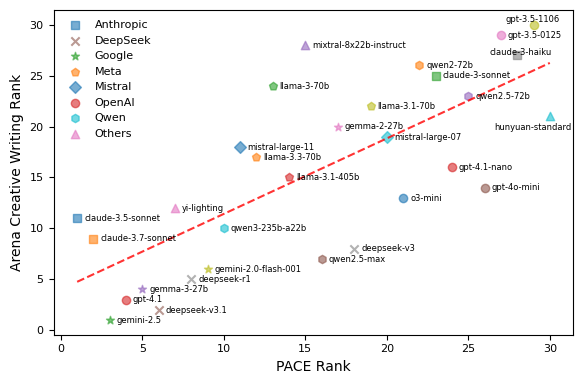

In [6]:
def get_model_name_short(model_name):
    mappings = {
        'gemini-2.5-pro-preview-03-25': 'gemini-2.5',
        'deepseek-chat-v3-0324': 'deepseek-v3.1',
        'gpt-4.1-2025-04-14': 'gpt-4.1',
        'deepseek-r1': 'deepseek-r1',
        'gemma-3-27b-it': 'gemma-3-27b',
        'deepseek-v3': 'deepseek-v3',
        'o3-mini-2025-01-31': 'o3-mini',
        'yi-lightning': 'yi-lighting',
        'claude-3.5-sonnet': 'claude-3.5-sonnet',
        'claude-3.7-sonnet': 'claude-3.7-sonnet',
        'gpt-4o-mini-2024-07-18': 'gpt-4o-mini',
        'llama-3.3-70b-instruct': 'llama-3.3-70b',
        'mistral-large-2407': 'mistral-large-07',
        'mistral-large-2411': 'mistral-large-11',
        'gemma-2-27b-it': 'gemma-2-27b',
        'mistral-8x22b-instruct': 'mistral-8x22b',
        'llama-3.1-405b-instruct': 'llama-3.1-405b',
        'llama-3.1-70b-instruct': 'llama-3.1-70b',
        'qwen-max-2025-01-25': 'qwen2.5-max',
        'qwen2.5-72b-instruct': 'qwen2.5-72b',
        'qwen2-72b-instruct': 'qwen2-72b',
        'qwen2-7b-instruct': 'qwen2-7b',
        'gpt-3.5-turbo-0125': 'gpt-3.5-0125',
        'gpt-3.5-turbo-1106': 'gpt-3.5-1106',
        'llama-3-70b-instruct': 'llama-3-70b',
        'claude-3-haiku': 'claude-3-haiku',
        'deepseek-r1-distill-llama-70b': 'r1-llama-70b',
        'deepseek-r1-distill-qwen-32b': 'r1-qwen-32b'
    }

    if model_name in mappings:
        return mappings[model_name]
    else:
        return model_name


def plot_arena_creative_writing_correlations(association_distance_scores, arena_ranks, correlation_results,
                                            correlation_type="spearman"):
    company_markers = {
        "OpenAI": "o",  # Circle
        "Anthropic": "s",  # Square
        "Meta": "p",  # Pentagon
        "Google": "*",  # Star
        "Mistral": "D",  # Diamond
        "DeepSeek": "x",  # X mark
        "Qwen": "h",  # Hexagon, dedicated marker
        "Others": "^",  # Triangle
    }

    company_mappings = {
        "gpt": "OpenAI",
        "claude": "Anthropic",
        "llama": "Meta",
        "qwen": "Qwen",
        "mistral": "Mistral",
        "deepseek": "DeepSeek",
        "gemma": "Google",
        "gemini": "Google",
    }

    def get_company_from_model(model_name):
        if model_name == "o3-mini-2025-01-31":
            return "OpenAI"
        elif model_name == 'mistral-8x22b-instruct':
            return 'Mistral'
        for key in company_mappings:
            if key in model_name.lower():
                return company_mappings[key]
        return "Others"

    leaderboard = "arena_cw"  # Only for arena_creative_writing

    result = correlation_results.get(leaderboard)

    all_models_data = []
    x_values = []
    models = []
    marker_types = []

    x_label = "PACE Rank"
    y_label = "Arena Creative Writing Rank"

    for model, score in association_distance_scores.items():
        if model in arena_ranks and leaderboard in arena_ranks[model]:
            all_models_data.append(
                {
                    "model": model,
                    "association_distance": score,
                    "arena_value": arena_ranks[model][leaderboard],
                }
            )

    sorted_association_distance = sorted(all_models_data, key=lambda x: -x["association_distance"])
    for rank, data in enumerate(sorted_association_distance):
        x_values.append(rank + 1)
        models.append(data["model"])
        company_name = get_company_from_model(data["model"])
        marker_types.append(company_markers[company_name])

    sorted_arena = sorted(all_models_data, key=lambda x: -x["arena_value"])
    arena_rank_dict = {item["model"]: rank + 1 for rank, item in enumerate(sorted_arena)}
    y_values = [arena_rank_dict[model] for model in models]

    fig, ax = plt.subplots(figsize=(6, 4))

    for i, model in enumerate(models):
        company_name = get_company_from_model(model)
        marker_style = company_markers[company_name]
        offset_x, offset_y = 5, -2

        if model == "hunyuan-standard":
            offset_x = -40
            offset_y = -10
        if model == 'gpt-3.5-turbo-1106':
            offset_x = -20
            offset_y = +2
        if model == 'claude-3-haiku':
            offset_x = -20
            offset_y = 0

        ax.scatter(
            x_values[i],
            y_values[i],
            alpha=0.6,
            label=company_name if company_name not in ax.get_legend_handles_labels()[1] else "",
            marker=marker_style,
        )
        ax.annotate(
            get_model_name_short(model),
            (x_values[i], y_values[i]),
            xytext=(offset_x, offset_y),
            textcoords="offset points",
            fontsize=6,
        )

    z = np.polyfit(x_values, y_values, 1)
    p = np.poly1d(z)
    ax.plot(x_values, p(x_values), "r--", alpha=0.8)

    ax.set_xlabel(x_label, fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)

    max_x = max(x_values) if x_values else 1
    max_y = max(y_values) if y_values else 1
    ax.set_xticks(range(0, int(max_x) + 5, 5))
    ax.set_yticks(range(0, int(max_y) + 5, 5))

    handles_labels = dict(zip(ax.get_legend_handles_labels()[1], ax.get_legend_handles_labels()[0]))
    sorted_legends = {k: handles_labels[k] for k in sorted(handles_labels, key=lambda x: ("Others" in x, x))}
    ax.legend(sorted_legends.values(), sorted_legends.keys(), loc="upper left", fontsize=8, frameon=False)

    plt.tight_layout()
    output_path = rf"./{correlation_type}_correlations.pdf"
    plt.savefig(output_path, dpi=300, bbox_inches="tight", format='pdf')
    plt.show()

plot_arena_creative_writing_correlations(association_distance_scores, arena_ranks, correlation_results,
                                            correlation_type="spearman")